In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [1]:
import pandapower as pp
import pandas as pd
import matplotlib.pyplot as plt
import pandapower.networks as pn
import pandapower.topology as top
import pandapower.toolbox as tb
import copy
import networkx as nx

In [2]:
def is_grid_connected(net):
    graph = top.create_nxgraph(net, nogobuses=[], include_lines=True, include_trafos=True)
    connected_parts = list(nx.connected_components(graph))
    return len(connected_parts) == 1


def contingency_analysis(net, load, volt_high, volt_low, load_scale):
    contingency_results = []
    load=float(load)
    volt_high=float(volt_high)
    volt_low=float(volt_low)
    net.load['p_mw'] *= load_scale
    net.load['q_mvar'] *= load_scale
    try:
        pp.runpp(net, init='auto', max_iteration=100, numba=False, enforce_q_lims=True, check_connectivity=True)
    except Exception as e:
        raise RuntimeError(f"Base case power flow failed: {e}")


    base_case_features = {}

    for bus_id, vm in net.res_bus["vm_pu"].items():
        base_case_features[f"base_bus_voltage_{bus_id}"] = vm

    for line_id, loading in net.res_line["loading_percent"].items():
        base_case_features[f"base_line_loading_{line_id}"] = loading

    if not net.res_trafo.empty:
        for trafo_id, loading in net.res_trafo["loading_percent"].items():
            base_case_features[f"base_trafo_loading_{trafo_id}"] = loading



    for line in net.line.index:
        net_c = copy.deepcopy(net)
        net_c.line.at[line, "in_service"] = False
        try:
            if not is_grid_connected(net_c):
                raise RuntimeError("Grid disconnected — skipping runpp.")
            pp.runpp(net_c, init='auto', max_iteration=100, numba=False, enforce_q_lims=True, check_connectivity=True)
            result = {
                "contingency type": f"line {line}", "status": "passed",
                "from_bus": net.line.at[line, 'from_bus'], "to_bus": net.line.at[line, 'to_bus']
            }
            for bus_id, vm in net_c.res_bus["vm_pu"].items():
                result[f"bus_voltage_{bus_id}"] = vm

            for line_id, loading in net_c.res_line["loading_percent"].items():
                result[f"line_loading_{line_id}"] = loading

            if not net_c.res_trafo.empty:
                for trafo_id, loading in net_c.res_trafo["loading_percent"].items():
                    result[f"trafo_loading_{trafo_id}"] = loading

            line_violation = (net_c.res_line.loading_percent.dropna() > load).any()

            trafo_violation = False
            if not net_c.res_trafo.empty:
                trafo_violation = (net_c.res_trafo.loading_percent.dropna() > load).any()

            overvoltage_violation = (net_c.res_bus.vm_pu.dropna() > volt_high).any()
            undervoltage_violation = (net_c.res_bus.vm_pu.dropna() < volt_low).any()

            # Debug prints
            print(f"\nContingency: {result['contingency type']}")
            print("  Line Violation:", line_violation)
            print("  Trafo Violation:", trafo_violation)
            print("  Overvoltage:", overvoltage_violation)
            print("  Undervoltage:", undervoltage_violation)
            print("  Max Line Loading:", net_c.res_line.loading_percent.max())
            if not net_c.res_trafo.empty:
                print("  Max Trafo Loading:", net_c.res_trafo.loading_percent.max())
            print("  Max VM:", net_c.res_bus.vm_pu.max())
            print("  Min VM:", net_c.res_bus.vm_pu.min())

            # Final decision
            if line_violation or trafo_violation or overvoltage_violation or undervoltage_violation:
                result["status"] = "critical"
            else:
                result["status"] = "Not critical"
        except Exception as e:
            result = {
                "contingency type": f"line {line}", "status": "error",
                "from_bus": net.line.at[line, 'from_bus'], "to_bus": net.line.at[line, 'to_bus'],
                "ERROR": str(e)
            }
        contingency_results.append(result)


    for trafo in net.trafo.index:
        net_c = copy.deepcopy(net)
        net_c.trafo.at[trafo, "in_service"] = False
        try:
            if not is_grid_connected(net_c):
                raise RuntimeError("Grid disconnected — skipping runpp.")
            pp.runpp(net_c, init='auto', max_iteration=100, numba=False, enforce_q_lims=True, check_connectivity=True)

            result = {
                "contingency type": f"trafo {trafo}", "status": "passed",
                "from_bus": net.trafo.at[trafo, 'hv_bus'], "to_bus": net.trafo.at[trafo, 'lv_bus']
            }

            for bus_id, vm in net_c.res_bus["vm_pu"].items():
                result[f"bus_voltage_{bus_id}"] = vm

            for line_id, loading in net_c.res_line["loading_percent"].items():
                result[f"line_loading_{line_id}"] = loading

            if not net_c.res_trafo.empty:
                for trafo_id, loading in net_c.res_trafo["loading_percent"].items():
                    result[f"trafo_loading_{trafo_id}"] = loading

            line_violation = (net_c.res_line.loading_percent.dropna() > load).any()

            trafo_violation = False
            if not net_c.res_trafo.empty:
                trafo_violation = (net_c.res_trafo.loading_percent.dropna() > load).any()

            overvoltage_violation = (net_c.res_bus.vm_pu.dropna() > volt_high).any()
            undervoltage_violation = (net_c.res_bus.vm_pu.dropna() < volt_low).any()

            # Debug prints
            print(f"\nContingency: {result['contingency type']}")
            print("  Line Violation:", line_violation)
            print("  Trafo Violation:", trafo_violation)
            print("  Overvoltage:", overvoltage_violation)
            print("  Undervoltage:", undervoltage_violation)
            print("  Max Line Loading:", net_c.res_line.loading_percent.max())
            if not net_c.res_trafo.empty:
                print("  Max Trafo Loading:", net_c.res_trafo.loading_percent.max())
            print("  Max VM:", net_c.res_bus.vm_pu.max())
            print("  Min VM:", net_c.res_bus.vm_pu.min())

            # Final decision
            if line_violation or trafo_violation or overvoltage_violation or undervoltage_violation:
                result["status"] = "critical"
            else:
                result["status"] = "Not critical"
        except Exception as e:
            result = {
                "contingency type": f"trafo {trafo}", "status": "error",
                "from_bus": net.trafo.at[trafo, 'hv_bus'], "to_bus": net.trafo.at[trafo, 'lv_bus'],
                "ERROR": str(e)
            }
        contingency_results.append(result)


    for bus in net.bus.index:
        net_c = copy.deepcopy(net)
        connected_dict = tb.get_connected_elements_dict(net, buses=[bus])
        for element, indices in connected_dict.items():
            net_c[element].loc[indices, 'in_service'] = False
        net_c.bus.at[bus, 'in_service'] = False
        try:
            if not is_grid_connected(net_c):
                raise RuntimeError("Grid disconnected — skipping runpp.")
            pp.runpp(net_c, init='auto', max_iteration=100, numba=False, enforce_q_lims=True, check_connectivity=True)

            result = {
                "contingency type": f"bus {bus}", "status": "passed",
            }

            for bus_id, vm in net_c.res_bus["vm_pu"].items():
                result[f"bus_voltage_{bus_id}"] = vm

            for line_id, loading in net_c.res_line["loading_percent"].items():
                result[f"line_loading_{line_id}"] = loading

            if not net_c.res_trafo.empty:
                for trafo_id, loading in net_c.res_trafo["loading_percent"].items():
                    result[f"trafo_loading_{trafo_id}"] = loading


            line_violation = (net_c.res_line.loading_percent.dropna() > load).any()

            trafo_violation = False
            if not net_c.res_trafo.empty:
                trafo_violation = (net_c.res_trafo.loading_percent.dropna() > load).any()

            overvoltage_violation = (net_c.res_bus.vm_pu.dropna() > volt_high).any()
            undervoltage_violation = (net_c.res_bus.vm_pu.dropna() < volt_low).any()

            # Debug prints
            print(f"\nContingency: {result['contingency type']}")
            print("  Line Violation:", line_violation)
            print("  Trafo Violation:", trafo_violation)
            print("  Overvoltage:", overvoltage_violation)
            print("  Undervoltage:", undervoltage_violation)
            print("  Max Line Loading:", net_c.res_line.loading_percent.max())
            if not net_c.res_trafo.empty:
                print("  Max Trafo Loading:", net_c.res_trafo.loading_percent.max())
            print("  Max VM:", net_c.res_bus.vm_pu.max())
            print("  Min VM:", net_c.res_bus.vm_pu.min())

            # Final decision
            if line_violation or trafo_violation or overvoltage_violation or undervoltage_violation:
                result["status"] = "critical"
            else:
                result["status"] = "Not critical"
        except Exception as e:
            result = {
                "contingency type": f"bus {bus}", "status": "error",
                "ERROR": str(e)
            }
        contingency_results.append(result)

    for gen in net.gen.index:
        net_c = copy.deepcopy(net)
        net_c.gen.at[gen, "in_service"] = False

        try:
            if not is_grid_connected(net_c):
                raise RuntimeError("Grid disconnected — skipping runpp.")
            pp.runpp(net_c, init='auto', max_iteration=100, numba=False, enforce_q_lims=True, check_connectivity=True)

            result = {
                "contingency type": f"gen {gen}", "status": "passed",
                "from_bus": net.gen.at[gen, 'bus'],
                "to_bus": None
            }

            for bus_id, vm in net_c.res_bus["vm_pu"].items():
                result[f"bus_voltage_{bus_id}"] = vm

            for line_id, loading in net_c.res_line["loading_percent"].items():
                result[f"line_loading_{line_id}"] = loading

            if not net_c.res_trafo.empty:
                for trafo_id, loading in net_c.res_trafo["loading_percent"].items():
                    result[f"trafo_loading_{trafo_id}"] = loading

            line_violation = (net_c.res_line.loading_percent.dropna() > load).any()

            trafo_violation = False
            if not net_c.res_trafo.empty:
                trafo_violation = (net_c.res_trafo.loading_percent.dropna() > load).any()

            overvoltage_violation = (net_c.res_bus.vm_pu.dropna() > volt_high).any()
            undervoltage_violation = (net_c.res_bus.vm_pu.dropna() < volt_low).any()

            # Debug prints
            print(f"\nContingency: {result['contingency type']}")
            print("  Line Violation:", line_violation)
            print("  Trafo Violation:", trafo_violation)
            print("  Overvoltage:", overvoltage_violation)
            print("  Undervoltage:", undervoltage_violation)
            print("  Max Line Loading:", net_c.res_line.loading_percent.max())
            if not net_c.res_trafo.empty:
                print("  Max Trafo Loading:", net_c.res_trafo.loading_percent.max())
            print("  Max VM:", net_c.res_bus.vm_pu.max())
            print("  Min VM:", net_c.res_bus.vm_pu.min())

            # Final decision
            if line_violation or trafo_violation or overvoltage_violation or undervoltage_violation:
                result["status"] = "critical"
            else:
                result["status"] = "Not critical"

        except Exception as e:
            result = {
                "contingency type": f"gen {gen}", "status": "error",
                "from_bus": net.gen.at[gen, 'bus'], "to_bus": None,
                "ERROR": str(e)
            }

        contingency_results.append(result)


    df = pd.DataFrame(contingency_results)


    dataset=df.copy()
    dataset['critical'] = dataset['status'].map({'critical': 1, 'Not critical': 0, 'passed': 0,'error' : 1}).fillna(0).astype(int)
    dataset[["contingency_category", "element_index"]] = dataset["contingency type"].str.extract(r"(line|bus|trafo|gen)\s+(\d+)", expand=True)
    dataset["element_index"] = pd.to_numeric(dataset["element_index"], errors="coerce")
    contingency_encoded = pd.get_dummies(dataset["contingency_category"], prefix="type").astype(int)
    for col in ['type_line', 'type_bus', 'type_trafo', 'type_gen']:
        if col not in contingency_encoded.columns:
            contingency_encoded[col] = 0
    contingency_encoded = contingency_encoded[['type_line', 'type_bus', 'type_trafo', 'type_gen']]
    dataset = pd.concat([dataset, contingency_encoded], axis=1)
    dataset.drop(['ERROR','status','contingency_category','contingency type'],axis=1,inplace=True)

    front_cols = ["element_index"] + list(contingency_encoded.columns)
    other_cols = [col for col in dataset.columns if col not in front_cols]
    dataset = dataset[front_cols + other_cols]
    gen_buses = set(net.gen['bus'].tolist())


    def compute_gen_presence(row):
        if row['type_bus'] == 1:
            bus_idx = int(row['element_index'])
            return int(bus_idx in gen_buses)
        else:
            return 0


    dataset['gen_present_at_element_bus'] = dataset.apply(compute_gen_presence, axis=1)

    non_numeric = dataset[['from_bus', 'to_bus']]

    for col in dataset.columns:
        if col not in non_numeric:
            dataset.fillna(dataset.median(numeric_only=True), inplace=True)
        else:
            pass
    return dataset


In [3]:
net_t = pn.case118()
dataset = contingency_analysis(net_t, 110, 1.08, 0.92, 1.0)

C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packag


Contingency: line 0
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.598757855680977
  Max VM: 1.05
  Min VM: 0.943

Contingency: line 1
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.5572347743157184
  Max VM: 1.05
  Min VM: 0.9319632488659421

Contingency: line 2
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056151
  Max Trafo Loading: 3.4015744949493705
  Max VM: 1.05
  Min VM: 0.9429999999999997

Contingency: line 3
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.493312062294235
  Max VM: 1.05
  Min VM: 0.9430000000000002

Contingency: line 4
  Line Violation: False
  Trafo Violation: False
  Ove

In [4]:
critical_counts = dataset['critical'].value_counts()

# Calculate percentages
total = critical_counts.sum()
critical_percentage = (critical_counts[1] / total) * 100 if 1 in critical_counts else 0
non_critical_percentage = (critical_counts[0] / total) * 100 if 0 in critical_counts else 0

print(f"Critical cases: {critical_counts.get(1, 0)} ({critical_percentage:.2f}%)")
print(f"Non-critical cases: {critical_counts.get(0, 0)} ({non_critical_percentage:.2f}%)")

Critical cases: 88 (24.65%)
Non-critical cases: 269 (75.35%)


# CONVERTING DATA TO GNN STRUCTURE

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric as tt
import seaborn as sns
import numpy as np

In [6]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix, precision_score, recall_score,roc_auc_score
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch.nn import Linear
from sklearn.preprocessing import StandardScaler
import random
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
from torch.nn import Linear, Sequential, ReLU
from torch_geometric.nn import NNConv, global_mean_pool, global_max_pool
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import LayerNorm

In [ ]:
def build_edge_index_from_net(net, bidirectional=True):
    from_line = list(net.line['from_bus'])
    to_line = list(net.line['to_bus'])

    from_trafo = list(net.trafo['hv_bus'])
    to_trafo = list(net.trafo['lv_bus'])

    from_bus = from_line + from_trafo
    to_bus = to_line + to_trafo

    edge_from = from_bus.copy()
    edge_to = to_bus.copy()

    if bidirectional:
        edge_from += to_bus
        edge_to += from_bus

    edge_index = torch.tensor([edge_from, edge_to], dtype=torch.long)
    return edge_index

def row_to_graph(

    row,
    edge_index,
    num_buses,
    line_count,
    trafo_count,
    load_scale
):

    bus_voltage_cols = [f"bus_voltage_{i}" for i in range(num_buses)]
    voltages = torch.tensor([row.get(col, 1.0) for col in bus_voltage_cols], dtype=torch.float)

    is_outaged = torch.zeros(num_buses)
    if row.get('type_bus', 0) == 1 and not pd.isna(row['element_index']):
        bus_idx = int(row['element_index'])
        if 0 <= bus_idx < num_buses:
            is_outaged[bus_idx] = 1.0

    gen_presen = torch.zeros(num_buses)
    if row.get('gen_present_at_element_bus', 0) == 1 and not pd.isna(row['element_index']):
        bus_idx = int(row['element_index'])
        if 0 <= bus_idx < num_buses:
            gen_presen[bus_idx] = 1.0

    node_features = torch.stack([voltages, is_outaged, gen_presen], dim=1)
    edge_attr = []
    for i in range(line_count + trafo_count):
        if i < line_count:
            loading = row.get(f'line_loading_{i}', 0.0)
            is_line, is_trafo = 1, 0
        else:
            trafo_idx = i - line_count
            loading = row.get(f'trafo_loading_{trafo_idx}', 0.0)
            is_line, is_trafo = 0, 1

        is_outaged_edge = 0
        if row.get('type_line', 0) == 1 and is_line and row['element_index'] == i:
            is_outaged_edge = 1
        elif row.get('type_trafo', 0) == 1 and is_trafo and row['element_index'] == i:
            is_outaged_edge = 1

        edge_attr.append([loading, is_line, is_trafo, is_outaged_edge])

    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    if edge_index.shape[1] == 2 * (line_count + trafo_count):  # bidirectional
        edge_attr = torch.cat([edge_attr, edge_attr], dim=0)

    y = torch.tensor([row['critical']], dtype=torch.long)

    contingency_type = torch.tensor([
        row.get('type_line', 0),
        row.get('type_bus', 0),
        row.get('type_trafo', 0),
        row.get('type_gen', 0)
    ], dtype=torch.float)

    data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
    )
    data.contingency_type = contingency_type.unsqueeze(0)
    data.load_scale = torch.tensor([load_scale], dtype=torch.float)
    return data

load_scales = [1.0, 1.25, 1.5]
all_data = []
all_contingencies_df = []


networks = {
    "case57": pn.case57(),
    "case39" : pn.case39(),
    "case30": pn.case30(),
    "case14": pn.case14(),
    "case9" : pn.case9()
}

thresholds = [
    (110, 1.07, 0.69),
    (110, 1.1, 0.75),
    (112, 1.1, 0.85),
    (108, 1.09, 0.92),
    (110, 1.1, 0.9)
]


for (name, base_net), (line_limit, v_max, v_min) in zip(networks.items(), thresholds):
    for scale in load_scales:
        print(f"Processing {name} with load scale {scale}")
        net = copy.deepcopy(base_net)
        try:
          contingency_df = contingency_analysis(net, line_limit, v_max, v_min, load_scale=scale)
        except Exception as e:
          print(f" Skipping {name} at load scale {scale} due to error: {e}")
          continue

        contingency_df["network_name"] = name
        contingency_df["load_scale"] = scale
        all_contingencies_df.append(contingency_df)

        edge_index = build_edge_index_from_net(net)
        num_buses = len(net.bus)
        line_count = len(net.line)
        trafo_count = len(net.trafo)

        for _, row in contingency_df.iterrows():
            data = row_to_graph(
                row,
                edge_index=edge_index,
                num_buses=num_buses,
                line_count=line_count,
                trafo_count=trafo_count,
                load_scale=scale
            )
            data.network_name = name
            data.load_scale = scale
            all_data.append(data)

net_118 = pn.case118()
scale = 1.0

print(f"Processing case118 with load scale {scale}")
try:
    contingency_df_118 = contingency_analysis(net_118, 109, 1.07, 0.93, load_scale=scale)
except Exception as e:
    print(f" Skipping case118 due to error: {e}")
else:
    contingency_df_118["network_name"] = "case118"
    contingency_df_118["load_scale"] = scale
    all_contingencies_df.append(contingency_df_118)

    edge_index = build_edge_index_from_net(net_118)
    num_buses = len(net_118.bus)
    line_count = len(net_118.line)
    trafo_count = len(net_118.trafo)

    for _, row in contingency_df_118.iterrows():
        data = row_to_graph(
            row,
            edge_index=edge_index,
            num_buses=num_buses,
            line_count=line_count,
            trafo_count=trafo_count,
            load_scale=scale
        )
        data.network_name = "case118"
        data.load_scale = scale
        all_data.append(data)

torch.save(all_data, "gnn_dataset_all_ieee.pt")
final_df = pd.concat(all_contingencies_df, ignore_index=True)
final_df.to_excel("all_ieee_contingency_data.xlsx", index=False)

C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packag

Processing case57 with load scale 1.0

Contingency: line 0
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 2.189875222782802
  Max Trafo Loading: 0.6964650709444536
  Max VM: 1.04
  Min VM: 0.718783067772538

Contingency: line 1
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 2.165052351616283
  Max Trafo Loading: 0.6967679614259162
  Max VM: 1.04
  Min VM: 0.719233523989209

Contingency: line 2
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 1.5572655199875247
  Max Trafo Loading: 0.648882095522088
  Max VM: 1.04
  Min VM: 0.7158465517431406

Contingency: line 3
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 1.7399452339648454
  Max Trafo Loading: 0.7056466129437524
  Max VM: 1.04
  Min VM: 0.7198036541726582

Contingency: line 4
  

C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packages\pandapower\io_utils.py:501: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
C:\Users\adith\anaconda3\Lib\site-packag

Processing case118 with load scale 1.0

Contingency: line 0
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.598757855680977
  Max VM: 1.05
  Min VM: 0.943

Contingency: line 1
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.5572347743157184
  Max VM: 1.05
  Min VM: 0.9319632488659421

Contingency: line 2
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056151
  Max Trafo Loading: 3.4015744949493705
  Max VM: 1.05
  Min VM: 0.9429999999999997

Contingency: line 3
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 3.493312062294235
  Max VM: 1.05
  Min VM: 0.9430000000000002

Contingency: line 4
  Line Violatio

In [ ]:
critical_counts = final_df['critical'].value_counts()

# Calculate percentages
total = critical_counts.sum()
critical_percentage = (critical_counts[1] / total) * 100 if 1 in critical_counts else 0
non_critical_percentage = (critical_counts[0] / total) * 100 if 0 in critical_counts else 0

print(f"Critical cases: {critical_counts.get(1, 0)} ({critical_percentage:.2f}%)")
print(f"Non-critical cases: {critical_counts.get(0, 0)} ({non_critical_percentage:.2f}%)")

Critical cases: 658 (57.77%)
Non-critical cases: 481 (42.23%)


# Training

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

set_seed(42)

full_dataset = torch.load("gnn_dataset_all_ieee.pt", weights_only=False)

labels = [data.y.item() for data in full_dataset]
train_data, val_data = train_test_split(
    full_dataset, test_size=0.2, stratify=labels, random_state=42
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class GNN(torch.nn.Module):
    def __init__(self, in_channels=3, edge_channels=4, hidden_channels=128):
        super(GNN, self).__init__()

        self.nn1 = Sequential(
            Linear(edge_channels, 128),
            ReLU(),
            Linear(128, in_channels * hidden_channels)
        )
        self.nn2 = Sequential(
            Linear(edge_channels, 128),
            ReLU(),
            Linear(128, hidden_channels * hidden_channels)
        )
        self.nn3 = Sequential(
            Linear(edge_channels, 128),
            ReLU(),
            Linear(128, hidden_channels * hidden_channels)
        )

        self.conv1 = NNConv(in_channels, hidden_channels, self.nn1, aggr='mean')
        self.conv2 = NNConv(hidden_channels, hidden_channels, self.nn2, aggr='mean')
        self.conv3 = NNConv(hidden_channels, hidden_channels, self.nn3, aggr='mean')

        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)
        self.norm3 = LayerNorm(hidden_channels)

        self.dropout = torch.nn.Dropout(0.3)
        self.lin = Linear(2 * hidden_channels + 4 + 1, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = self.norm3(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.dropout(x)

        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x_pool = torch.cat([x_mean, x_max], dim=1)
        load_scale = data.load_scale.unsqueeze(1).to(x.device)
        x_cat = torch.cat([x_pool, data.contingency_type.to(x.device), load_scale], dim=1)

        return self.lin(x_cat)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #gpu check
model = GNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2) #controls learning rate
labels = [data.y.item() for data in full_dataset]
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
weight = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weight) #loss funtion

In [ ]:
def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += batch.y.size(0)

    acc = correct / total
    return total_loss / len(train_loader), acc

def validate():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:

            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    acc = correct / total
    return total_loss / len(val_loader), acc

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []
best_val_acc = 0
for epoch in range(1,201):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Train Accuracy : {train_acc:.2%} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 001 | Train Loss: 0.7016 | Train Accuracy : 64.32% | Val Loss: 0.6529 | Val Acc: 73.25%
Epoch 002 | Train Loss: 0.5941 | Train Accuracy : 71.57% | Val Loss: 0.5967 | Val Acc: 73.25%
Epoch 003 | Train Loss: 0.5326 | Train Accuracy : 75.41% | Val Loss: 0.5536 | Val Acc: 77.63%
Epoch 004 | Train Loss: 0.5122 | Train Accuracy : 74.64% | Val Loss: 0.5314 | Val Acc: 80.26%
Epoch 005 | Train Loss: 0.5093 | Train Accuracy : 75.63% | Val Loss: 0.4962 | Val Acc: 80.70%
Epoch 006 | Train Loss: 0.4623 | Train Accuracy : 77.72% | Val Loss: 0.4510 | Val Acc: 82.02%
Epoch 007 | Train Loss: 0.4606 | Train Accuracy : 78.27% | Val Loss: 0.4489 | Val Acc: 82.46%
Epoch 008 | Train Loss: 0.4457 | Train Accuracy : 79.91% | Val Loss: 0.4333 | Val Acc: 82.46%
Epoch 009 | Train Loss: 0.4371 | Train Accuracy : 80.68% | Val Loss: 0.4511 | Val Acc: 85.09%
Epoch 010 | Train Loss: 0.4221 | Train Accuracy : 81.01% | Val Loss: 0.4409 | Val Acc: 84.21%
Epoch 011 | Train Loss: 0.3982 | Train Accuracy : 82.11% | V

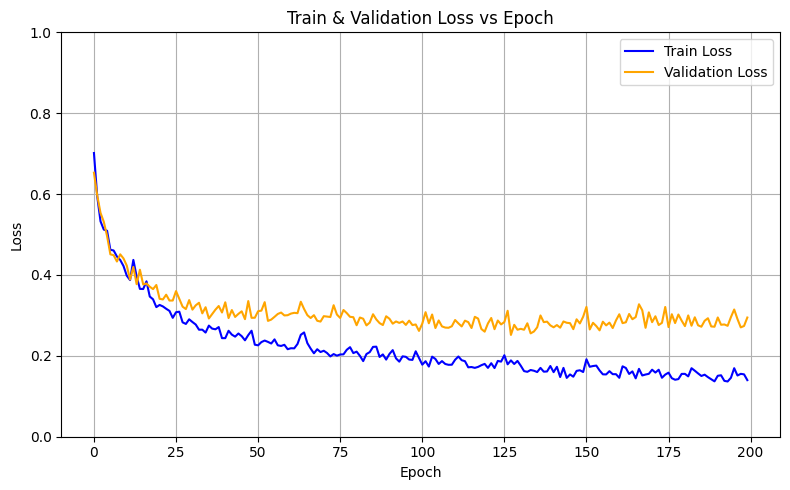

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


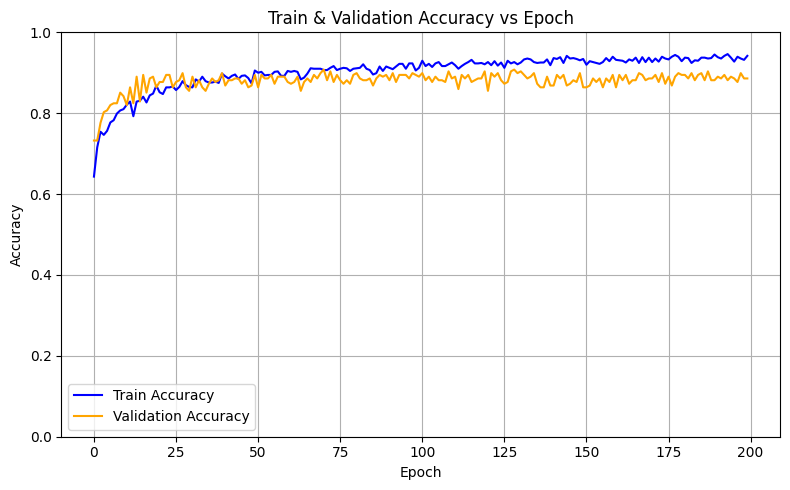

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [ ]:
from torch.nn.functional import softmax

# TESTING

In [ ]:
net_test = pn.case118()
load_scale_test = 1.25
print(f"Testing case118 at load scale {load_scale_test}")

edge_index_test = build_edge_index_from_net(net_test, bidirectional=True)

test_df = contingency_analysis(net_test, 120, 1.2, 0.9, load_scale=load_scale_test)

num_buses = len(net_test.bus)
line_count = len(net_test.line)
trafo_count = len(net_test.trafo)

data_list_test = [
    row_to_graph(row, edge_index=edge_index_test,
                 num_buses=num_buses,
                 line_count=line_count,
                 trafo_count=trafo_count,
                 load_scale=load_scale_test)
    for _, row in test_df.iterrows()
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_loader = DataLoader(data_list_test, batch_size=1)
predictions = []
threshold = 0.46
probs = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        prob = softmax(output, dim=1)[0, 1].item()
        probs.append(prob)
        pred = 1 if prob >= threshold else 0
        predictions.append(pred)


test_df["predicted_critical"] = predictions
print(test_df[["element_index", "type_line", "type_trafo", "type_gen", "critical", "predicted_critical"]])

test_df.to_excel(f"gnn_test_predictions_case118_load{load_scale_test}.xlsx", index=False)

Testing case118 at load scale 1.25

Contingency: line 0
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056156
  Max Trafo Loading: 7.1049877931585765
  Max VM: 1.0500000000000003
  Min VM: 0.9257123164624662

Contingency: line 1
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056162
  Max Trafo Loading: 7.120417381664596
  Max VM: 1.05
  Min VM: 0.9010658565569194

Contingency: line 2
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.47508732405615
  Max Trafo Loading: 7.133473990910215
  Max VM: 1.05
  Min VM: 0.9255230993543239

Contingency: line 3
  Line Violation: False
  Trafo Violation: False
  Overvoltage: False
  Undervoltage: False
  Max Line Loading: 4.475087324056161
  Max Trafo Loading: 7.1400732426608435
  Max VM: 1.05
  Min VM: 0.9121531509508313

Contingency: 

# EVALUATION METRICS


In [ ]:
y_true = test_df["critical"]
y_pred = test_df["predicted_critical"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Accuracy: 0.9355742296918768
Precision: 0.9578947368421052
Recall: 0.8272727272727273
F1 Score: 0.8878048780487805
Confusion Matrix:
 [[243   4]
 [ 19  91]]


In [ ]:
print("Class distribution actually:")
print(y_true.value_counts())

print("Class distribution in predictions:")
print(pd.Series(y_pred).value_counts())


Class distribution actually:
critical
0    247
1    110
Name: count, dtype: int64
Class distribution in predictions:
predicted_critical
0    262
1     95
Name: count, dtype: int64


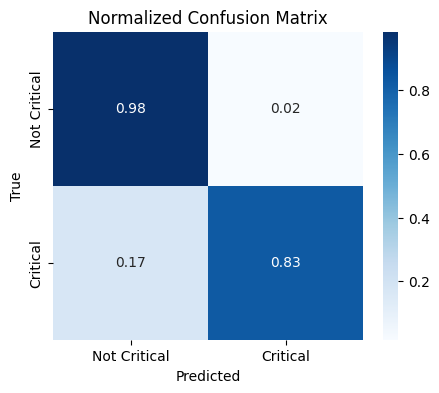

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2f",
            xticklabels=["Not Critical", "Critical"],
            yticklabels=["Not Critical", "Critical"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# PLOTTING

In [ ]:
import pandapower.plotting as plot
import pandapower.plotting.plotly as plotlypp
import pandapower.plotting as plot
import matplotlib.patches as mpatches

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go

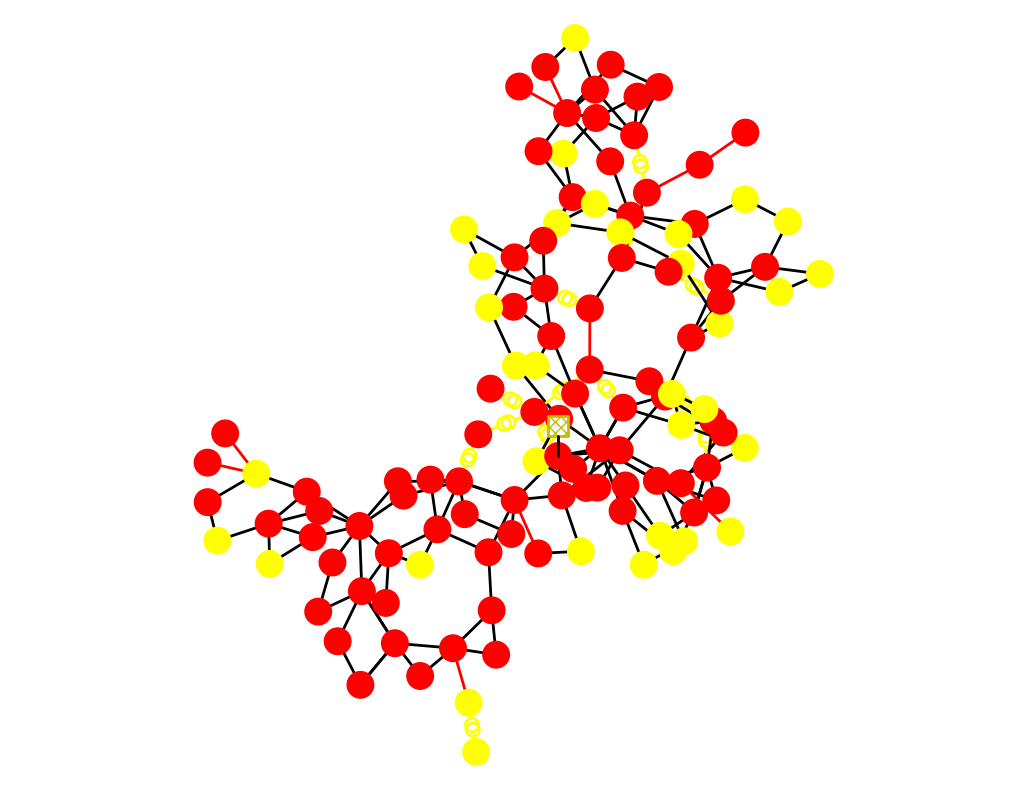

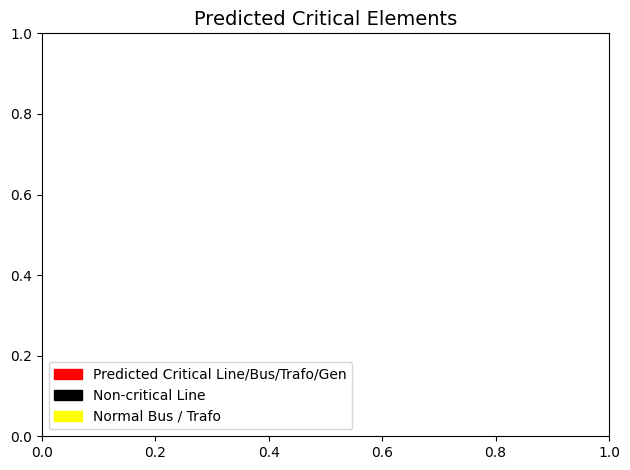

In [ ]:
net_test = pn.case118()
load_scale_test = 1.25

def get_element_indices(df, element_type, label):
    return df[(df[element_type] == 1) & (df[label] == 1)]["element_index"].dropna().astype(int).tolist()

pred_lines = get_element_indices(test_df, "type_line", "predicted_critical")
pred_trafo = get_element_indices(test_df, "type_trafo", "predicted_critical")
pred_gens = get_element_indices(test_df, "type_gen", "predicted_critical")
pred_buses = get_element_indices(test_df, "type_bus", "predicted_critical")

pred_gen_buses = net_test.gen.loc[pred_gens, 'bus'].tolist() if len(pred_gens) > 0 else []

def build_predicted_colors(net, predicted_list, color_pred, default_color="black"):
    colors = []
    for i in net.index:
        if i in predicted_list:
            colors.append(color_pred)
        else:
            colors.append(default_color)
    return colors

line_colors_pred = build_predicted_colors(net_test.line, pred_lines, 'red', default_color='black')
trafo_colors_pred = build_predicted_colors(net_test.trafo, pred_trafo, 'red', default_color='yellow')
bus_colors_pred = build_predicted_colors(net_test.bus, pred_buses + pred_gen_buses, 'red', default_color='yellow')

def plot_network(net, line_colors, trafo_colors, bus_colors, title, filename):
    fig, ax = plt.subplots(figsize=(13, 10))
    plot.simple_plot(net,
                     line_color=line_colors,
                     trafo_color=trafo_colors,
                     bus_color=bus_colors,
                     line_width=2,
                     bus_size=2,
                     ax=ax)

    plt.title('Predicted Critical Elements', fontsize=14)

    legend_elements = [
        mpatches.Patch(color='red', label='Predicted Critical Line/Bus/Trafo/Gen'),
        mpatches.Patch(color='black', label='Non-critical Line'),
        mpatches.Patch(color='yellow', label='Normal Bus / Trafo')
    ]
    plt.legend(handles=legend_elements, loc='lower left')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_network(
    net_test,
    line_colors_pred,
    trafo_colors_pred,
    bus_colors_pred,
    title=f"IEEE 118 — Predicted Critical Contingencies (Load Scale {load_scale_test})",
    filename=f"predicted_critical_case118_load{load_scale_test}.png"
)
